## 交通標誌圖像辨識 (Traffic Sign Recognition)

在這篇文章裡, 我們將通過解決一個現實世界的問題來練手深度學習。
我們要使用的圖像是[德國交通標誌識別基準（GTSRB）](http://benchmark.ini.rub.de/?section=gtsrb&subsection=news)資料集。問題是要識別圖像中不同種類的交通標誌。解決這個問題對於自駕車在道路上行駛至關重要。

![GTSRB](https://chsasank.github.io/assets/images/traffic/classes.jpg)

這個數據集裡面的圖像具有不同大小，光照條件，遮擋情況下的43種不同交通標誌符號，圖像的成像情況與真實你實際在不同時間點下去
路邊開車走路時看到的交通標誌的情形非常相似。訓練集包括大約39,000個圖像，而測試集大約有12,000個圖像。圖像不能保證是固定
的尺寸，標誌不一定在每個圖像中都是居中。每個圖像包含實際交通標誌周圍10％左右的邊界。

在進行後面的相關動作之前, 你需要從[GTSRB網站](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset)下載"Images and annotations”(圖像資料與標籤資訊)"以便進行模型的訓練和測試，並將其解壓縮到一個文件夾中。
同時再另外下載'Extended annotations including class ids'資料集來作為模型的測試集。
我們在這個範列中會將以上的資料組織鳥戮如下標示的目錄結構：

    GTSRB
    ├── GT-final_test.csv
    ├── Final_Test
    │   └── Images
    └── Final_Training
        └── Images
            ├── 00000
            ├── 00001
            ├── ...
            ├── 00041
            └── 00042

## 資料預處理 (Data Preprocessing)


In [2]:
import warnings
warnings.filterwarnings('ignore') # 把一些惱人的警示訊息暫時忽略

import numpy as np
from skimage import io, color, exposure, transform
from sklearn.model_selection import train_test_split
import os
import glob
import h5py

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

from keras.optimizers import SGD
import keras.utils as np_utils
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

from matplotlib import pyplot as plt

%matplotlib inline

NUM_CLASSES = 43 # 共有43種要辨識的交通標誌
IMG_SIZE = 48 # 每張圖像最後都要整理成 48x48的大小

Using TensorFlow backend.


### 圖像亮度直方圖均衡化 (Histogram equalization)

從上面的代表性圖像可以看出，圖像在亮度上(illumination)有很大的差異不同。他們也有不同的大小。所以，我們來編寫一個函數，在HSV顏色空間中進行直方圖均衡，並將圖像調整為成一樣的標準大小。

"[直方圖均衡化](https://zh.wikipedia.org/wiki/%E7%9B%B4%E6%96%B9%E5%9B%BE%E5%9D%87%E8%A1%A1%E5%8C%96)"是圖像處理領域中利用圖像`直方圖`對`對比度`進行調整的方法。

這種方法通常用來增加許多圖像的全局對比度，尤其是當圖像的有用數據的對比度相當接近的時候。通過這種方法，亮度可以更好地在直方圖上分布。這樣就可以用於增強局部的對比度而不影響整體的對比度，直方圖均衡化通過有效地擴展常用的亮度來實現這種功能。

這種方法對於背景和前景都太亮或者太暗的圖像非常有用, 而且它是一個相當直觀的技術並且是可逆操作，如果已知均衡化函數，那麼就可以恢復原始的直方圖，並且計算量也不大。 但是這種方法的一個缺點是它它可能會增加背景雜訊的對比度並且降低有用訊號的對比度。

詳細說明請見: [Wikipedia-直方圖均衡化](https://zh.wikipedia.org/wiki/%E7%9B%B4%E6%96%B9%E5%9B%BE%E5%9D%87%E8%A1%A1%E5%8C%96)

### 處理前:
![Input image to preprocess_img(scaled 4x)](https://chsasank.github.io/assets/images/traffic/input.png "Input image to preprocess_img(scaled 4x)")

### 處理後:
![Processed image (scaled 4x)](https://chsasank.github.io/assets/images/traffic/output.png "Processed image (scaled 4x)")

### 圖像大小的修改 (Image Resizing)

由於圖像具有不同的形狀和大小，因此我們必須對圖像進行歸一化(normalize)處理以便可以決定模型的輸入。
在這個範例我們選擇使用48x48的圖像大小。你也可以嘗試使用比較小的圖像比如32x32或24x24看看是不是也可得到類似的準確率。

In [3]:
# 用來對圖像進行處理的函式
import os
from pathlib import PurePath # 處理不同作業系統file path的解析問題 (*nix vs windows)

# 圖像標高度均衡、置中及大小調整
def preprocess_img(img):
    # 進行"直方圖均衡化"處理
    hsv = color.rgb2hsv(img) # 對彩色分量rgb分別做均衡化，會產生奇異的點，圖像不和諧。一般採用的是用hsv空間進行亮度的均衡
    hsv[:,:,2] = exposure.equalize_hist(hsv[:,:,2])
    img = color.hsv2rgb(hsv) # 再把圖像從hsv轉回rgb
    
    # 進行圖像置中
    min_side = min(img.shape[:-1])
    centre = img.shape[0]//2, img.shape[1]//2
    img = img[centre[0]-min_side//2:centre[0]+min_side//2,
              centre[1]-min_side//2:centre[1]+min_side//2,
              :]
    
    # 改變大小
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))    
    return img

# 取得圖像檔的分類標籤
def get_class(img_path):
    # 圖像檔所在的檔案夾名稱就是該圖像檔的分類標籤
    return int(PurePath(img_path).parts[-2])

### 圖像處理並轉換成numpy ndarray

讓我們預處理所有的訓練圖像並以numpy數組來存儲到檔案系統中。過程中我們還會從圖像檔的檔案路徑中獲取圖片的標籤。
我們會將標籤(label)資料進行one-hot編碼：

In [4]:
# 從檔案系統中把保留的資料載入(如果沒有就進行第一次的資料轉換處理)
try:
    with h5py.File('X.h5') as hf:
        X, Y = hf['imgs'][:], hf['labels'][:]
    
    print("Loaded images from X.h5")
    
except(IOError, OSError, KeyError):
    print("Error in reading X.h5. Processing all images...")
    root_dir = 'GTSRB/Final_Training/Images/'
    imgs = []
    labels = []
    
    all_img_paths = glob.glob(os.path.join(root_dir, '*/*.ppm')) # 我們有 Test與Traing兩個檔案夾的資料要處理
    np.random.shuffle(all_img_paths) # 進行打散
    for img_path in all_img_paths:
        try:
            img = preprocess_img(io.imread(img_path))
            label = get_class(img_path)
            imgs.append(img) # 保留圖像資料
            labels.append(label) # 保留圖像標籤
            
            if len(imgs)%1000 == 0:
                print("Processed {}/{}".format(len(imgs), len(all_img_paths))) # 每1000筆秀一下進度
        except(IOError, OSError):
            print('missed', img_path)
            pass
        
    X = np.array(imgs, dtype='float32') # 將資料轉換成numpy的ndarray, 資料型別為float32
    Y = np.eye(NUM_CLASSES, dtype='uint8')[labels] # 對labels的資料進行one-hot (使用numpy.eye的函式)
    
    # 將處理過圖像資料與標籤保持在檔案系統, 下次可以加速載入與處理
    with h5py.File('X.h5', 'w') as hf:
        hf.create_dataset('imgs', data=X)
        hf.create_dataset('labels', data=Y)

Loaded images from X.h5


## 網絡模型 (Model)


現在我們來定義我們的模型架構。我們將使用具有6個卷積層的前饋網絡，然後是完全連接的隱藏層。
我們也將在兩者之間使用Dropout層來防止網絡"過擬合(overfitting)"。

In [5]:
# 產生一個Keras序貫模型
def cnn_model():
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))    
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    return model;   

model = cnn_model() # 初始化一個模型
model.summary() # 秀出模型架構


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 23, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 23, 23, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 64)        0         
__________

在訓練模型之前，我們需要將模型配置為學習算法並進行編譯。我們需要指定:
* `loss`: 損失函數，我們要優化。我們不能使用`MSE`，因為它是不連續的數值。因此，我們使用：`categorical_crossentropy`
* `optimizer`: 我們使用標準隨機梯度下降(Stochastic gradient descent)與涅斯捷羅夫動量(Nesterov momentum)
* `metric`: 由於我們正在處理一個分類問題，我們用度量是`accuracy`。

In [6]:
# 讓我們先配置一個常用的組合來作為後續優化的基準點
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
             optimizer=sgd,
             metrics=['accuracy'])

## 訓練 (Training)

現在，我們的模型已經準備好了。在訓練期間，我們的模型將進行迭代批量訓練，每個次的訓練資料的大小為batch_size。對於每批次，模型將會計算出梯度(gradient)，並自動更新網絡的權重。對所有訓練集的一次迭代被稱為一次的循環(epoch)。訓練通常會一直進行到損失收斂於一個常數。


我們將增加一些功能到我們的訓練設定：
* `Learning rate scheduler`: 隨著訓練循環的次數逐漸增加的過程中對權重調整的學習率進行衰減通常有助於讓模型學習更好
* `Model checkpoint`: 我們將比對每個訓練循環的驗證準確度並只保存模型表現最好的模型。這對深度學度來說是很有用的設定，因為我們的網絡可能在一定數量的訓練循環後開始過擬合(overfitting)，但是我們需要在整過訓練過程中表現最好的模型留下來。

這些設定不是必須的，但它們的確可以提高模型的準確性。這些功能是通過Keras的`callback`功能來實現的。`callback`是一組函式，將在訓練過程的特定階段被應用，比如將訓練結束。 Keras提供內置的學習速率調度([learning rate scheduling](https://keras.io/callbacks/#learningratescheduler) )和模型檢查點功能([model checkpointing](https://keras.io/callbacks/#modelcheckpoint))。

In [7]:
def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))

batch_size = 32
nb_epoch = 30

history = model.fit(X, Y,
         batch_size=batch_size,
         epochs=nb_epoch,
         validation_split=0.2,
         shuffle=True,
         callbacks=[LearningRateScheduler(lr_schedule),
             ModelCheckpoint('model.h5', save_best_only=True)
         ])

Train on 31367 samples, validate on 7842 samples
Epoch 1/30
31367/31367 [==============================] - 11s 339us/step - loss: 1.7234 - acc: 0.5070 - val_loss: 0.2577 - val_acc: 0.9204
Epoch 2/30
31367/31367 [==============================] - 10s 326us/step - loss: 0.2787 - acc: 0.9119 - val_loss: 0.1255 - val_acc: 0.9661
Epoch 3/30
31367/31367 [==============================] - 11s 335us/step - loss: 0.1571 - acc: 0.9509 - val_loss: 0.0638 - val_acc: 0.9806
Epoch 4/30
31367/31367 [==============================] - 11s 340us/step - loss: 0.1060 - acc: 0.9671 - val_loss: 0.0602 - val_acc: 0.9800
Epoch 5/30
31367/31367 [==============================] - 11s 344us/step - loss: 0.0875 - acc: 0.9729 - val_loss: 0.0489 - val_acc: 0.9856
Epoch 6/30
31367/31367 [==============================] - 10s 325us/step - loss: 0.0686 - acc: 0.9786 - val_loss: 0.0429 - val_acc: 0.9869
Epoch 7/30
31367/31367 [==============================] - 10s 328us/step - loss: 0.0616 - acc: 0.9811 - val_loss: 0.0

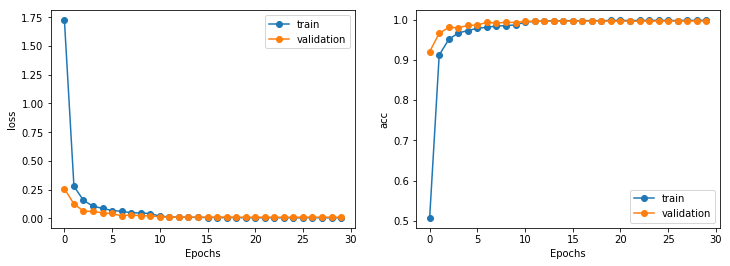

In [8]:
# 透過趨勢圖來觀察訓練與驗證的走向 (特別去觀察是否有"過擬合(overfitting)"的現象)
import matplotlib.pyplot as plt

def plot_train_history(history, train_metrics, val_metrics):
    plt.plot(history.history.get(train_metrics),'-o')
    plt.plot(history.history.get(val_metrics),'-o')
    plt.ylabel(train_metrics)
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])
    
    
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_train_history(history, 'loss','val_loss')

plt.subplot(1,2,2)
plot_train_history(history, 'acc','val_acc')

plt.show()

## 驗證評估 (Evaluation)

讓我們加載測試數據並評估我們的模型

In [9]:
# 載入測試資料
import pandas as pd
test = pd.read_csv('GTSRB/GT-final_test.csv', sep=';') # 裡面包含了六個欄位 Filename;Width;Height;Roi.X1;Roi.Y1;Roi.X2;Roi.Y2;ClassId

X_test = []
y_test = []

# 迭代處理每一筆要測試的圖像檔
i=0
for file_name, class_id in zip(list(test['Filename']),list(test['ClassId'])):
    img_path = os.path.join('GTSRB/Final_Test/Images/',file_name)
    X_test.append(preprocess_img(io.imread(img_path)))
    y_test.append(class_id)
    
# 轉換成numpy ndarray
X_test = np.array(X_test)
y_test = np.array(y_test)

print("X_test.shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)

X_test.shape:  (12630, 48, 48, 3)
y_test.shape:  (12630,)


In [10]:
# 預測與比對
y_pred = model.predict_classes(X_test)
acc = np.sum(y_pred==y_test)/np.size(y_pred)
print("Test accuracy = {}".format(acc))

12630/12630 [==============================] - 1s 116us/step
Test accuracy = 0.9707046714172605


### 哇! 我們在這樣的架構下就可以訓練出一個準確率達到**97%**的模型。與人類的平均表現相差不遠了（98.84%）

## 圖像增強 (Data Augmentation)

你可能會認為40,000圖像是很多的圖像。再想一想,我們的模型裡有1,358,155個參數。這是訓練圖像的數量的40多倍。
如果我們可以從現有的圖像生成新的訓練圖像，這將是一個很好的方式來增加訓練數據集的大小。

讓我們直接使用keras的內置功能來完成圖像增強 (Data Augmentation)。

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

datagen = ImageDataGenerator(featurewise_center=False, 
                            featurewise_std_normalization=False, 
                            rotation_range=10.,
                            width_shift_range=0.1,
                            height_shift_range=0.1,                             
                            shear_range=0.1,
                            zoom_range=0.2,
                            )

datagen.fit(X_train)

In [12]:
# 重新重置一個新的模型
model = cnn_model()

# 讓我們用相同的組合
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
             optimizer=sgd,
             metrics=['accuracy'])

def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))

batch_size = 32
nb_epoch = 30

# 透過data generator來產生訓練資料, 由於資料是可持續產生, 我們可以透過設定'steps_per_epoch'的數量來讓模型可以有更多的訓練批次
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                            steps_per_epoch=X_train.shape[0]/batch_size,
                            epochs=nb_epoch,
                            validation_data=(X_val, Y_val),
                            callbacks=[LearningRateScheduler(lr_schedule),
                                       ModelCheckpoint('model2.h5',save_best_only=True)]
                           )

Epoch 1/30
981/980 [==============================] - 14s 14ms/step - loss: 2.5697 - acc: 0.2650 - val_loss: 1.1405 - val_acc: 0.6341
Epoch 2/30
981/980 [==============================] - 14s 14ms/step - loss: 0.9100 - acc: 0.7102 - val_loss: 0.1976 - val_acc: 0.9338
Epoch 3/30
981/980 [==============================] - 14s 14ms/step - loss: 0.4247 - acc: 0.8645 - val_loss: 0.0777 - val_acc: 0.9748
Epoch 4/30
981/980 [==============================] - 14s 14ms/step - loss: 0.2750 - acc: 0.9142 - val_loss: 0.0568 - val_acc: 0.9811
Epoch 5/30
981/980 [==============================] - 14s 14ms/step - loss: 0.2022 - acc: 0.9380 - val_loss: 0.0382 - val_acc: 0.9878
Epoch 6/30
981/980 [==============================] - 14s 14ms/step - loss: 0.1674 - acc: 0.9508 - val_loss: 0.0206 - val_acc: 0.9936
Epoch 7/30
981/980 [==============================] - 14s 14ms/step - loss: 0.1443 - acc: 0.9556 - val_loss: 0.0244 - val_acc: 0.9929
Epoch 8/30
981/980 [==============================] - 14s 14ms

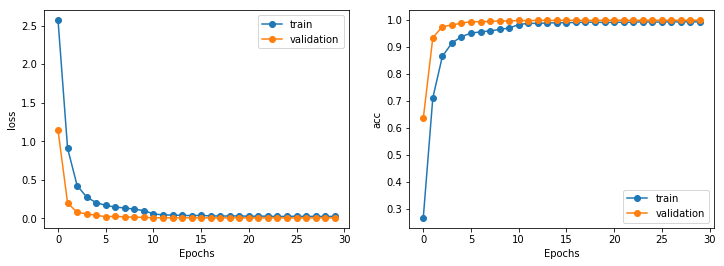

In [13]:
# 透過趨勢圖來觀察訓練與驗證的走向 (特別去觀察是否有"過擬合(overfitting)"的現象)
import matplotlib.pyplot as plt

def plot_train_history(history, train_metrics, val_metrics):
    plt.plot(history.history.get(train_metrics),'-o')
    plt.plot(history.history.get(val_metrics),'-o')
    plt.ylabel(train_metrics)
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'])
    
    
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_train_history(history, 'loss','val_loss')

plt.subplot(1,2,2)
plot_train_history(history, 'acc','val_acc')

plt.show()

In [14]:
# 預測與比對
y_pred = model.predict_classes(X_test)
acc = np.sum(y_pred==y_test)/np.size(y_pred)
print("Test accuracy = {}".format(acc))

12630/12630 [==============================] - 2s 119us/step
Test accuracy = 0.9870942201108472


## 驗證評估 (Evaluation)

透過圖像增強 (Data Augmentation)後再訓練的這個模型，我在測試集上獲得了`98.7%`的準確度(灑花! 灑花!)。

說正格的，我並沒有做太多的參數調校。以下列出一些可以嘗試改進模型的東西：
* 嘗試不同的網絡架構。嘗試更深和更淺的網絡。
* 嘗試添加`BatchNormalization`層到網絡。
* 嘗試不同的權重初始化
* 嘗試不同的學習速度和時間表
* 製作一個集成模型(ensemble models)
* 嘗試輸入圖像的正規化
* 更積極的數據增強(Data Augmentation)

這只是初學者的一種快速入門模型。對於這個問題的還有一些先進的解決方案，你可以看看[這個](http://torch.ch/blog/2015/09/07/spatial_transformers.html)，作者用一個稱為`Spatial Transformer`層的專門層
達到`99.61%`的準確度。

## 總結 (Conclusion)


在這篇文章中有一些個人學習到的一些有趣的重點:
* 對於圖像的成像亮度透過直方圖均衡化(Histogram equalization)可以輕鬆的調整 (又學到一招)
* 深度學習的卷積網絡真的對圖像的辨識有很好的效果
* 透過使用Keras的callback模組可以對模型的訓練過程有更多的監控與控制
* Keras的`ModelCheckpoint`真的很好用

參考:
* [Keras Tutorial - Traffic Sign Recognition](https://chsasank.github.io/keras-tutorial.html)
* [Keras官網](http://keras.io/)